In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import seaborn as sns

/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
train_dir = '../Project Code/X-rays/train/'
val_dir = '../Project Code/X-rays/val/'
test_dir = '../Project Code/X-rays/test/'

img_width, img_height = 224, 224  # Default input size for VGG16

In [3]:
# Instantiate convolutional base

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

In [4]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator


In [5]:
#Defining function for feature extraction and label creation 

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 12

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,3))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    



In [6]:
#Calling the feature extraction function on the train, test and validation datasets
#For running the training model, train_features would be X_train and train_labels would be y_train

train_features, train_labels = extract_features(train_dir, 760)  # Total no.of files in train folder
val_features, val_labels = extract_features(val_dir, 95)
test_features, test_labels = extract_features(test_dir, 95)

Found 760 images belonging to 3 classes.

Found 95 images belonging to 3 classes.
Found 95 images belonging to 3 classes.


In [7]:
#print(train_labels[0],'\n',train_labels[281],'\n',train_labels[484])
#print('\n',train_features[0])

print(train_features.shape)
print(train_labels.shape)
print(val_features.shape)


(760, 7, 7, 512)
(760, 3)
(95, 7, 7, 512)


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt

In [9]:
#Decision Tree classifier initialization

dt = tree.DecisionTreeClassifier(random_state=42)


In [10]:
#Flattening the features extraction to run the DT as it expects array of <= 2 dimensions
train_features_flatten = train_features.reshape((train_features.shape[0], 7 * 7 * 512))
val_features_flatten = val_features.reshape((val_features.shape[0], 7 * 7 * 512))
test_features_flatten = test_features.reshape((test_features.shape[0], 7 * 7 * 512))

In [11]:
#Shape of flattened features
print(train_features_flatten.shape)
print(val_features_flatten.shape)
print(test_features_flatten.shape)

(760, 25088)
(95, 25088)
(95, 25088)


In [12]:
#Training the DT model
dt.fit(train_features_flatten, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [13]:
dt_nodes = dt.tree_.node_count
dt_depth = dt.tree_.max_depth
dt_features = dt.tree_.n_features
dt_samples = dt.tree_.n_node_samples

print('Leaf Node: ',dt_nodes)
print('Max Depth: ',dt_depth)
print('Features: ',dt_features)
print('Samples: ',dt_samples)



Leaf Node:  113
Max Depth:  12
Features:  25088
Samples:  [760 218  55  45  28  21   7   4   3  17   2  15  10 163 159 157   1 156
   2   4   1   3 542 307 249 189 183 174 164 161 158 156 153 152   1   3
   1   2   2   1   1   3   3  10   5   5   2   3   9   7   2   6  60  34
  29  26   3   5  26  23   3  58  11  10   1  47  38  34   4   3   1   9
   4   1   3   5 235  23   6   4   2  17 212  42  28  25   1  24   3  14
  12   2 170 161   6   1   5 155 151 148 144 142 141   1   2   4   1   3
   3   4   9   7   2]


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
dt_train_pred = dt.predict(train_features_flatten)
print("\n\nClassification Matrix on Training Data:\n\n",classification_report(train_labels,dt_train_pred))
print("\n\nAccuracy on Training Data: ", accuracy_score(train_labels,dt_train_pred))



Classification Matrix on Training Data:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       280
           2       1.00      1.00      1.00       280

   micro avg       1.00      1.00      1.00       760
   macro avg       1.00      1.00      1.00       760
weighted avg       1.00      1.00      1.00       760
 samples avg       1.00      1.00      1.00       760



Accuracy on Training Data:  1.0


In [15]:
dt_val_pred = dt.predict(val_features_flatten)
print("\n\nClassification Matrix on Validation Data:\n\n",classification_report(val_labels,dt_val_pred))
print("\n\nAccuracy on Validation Data: ", accuracy_score(val_labels,dt_val_pred))



Classification Matrix on Validation Data:

               precision    recall  f1-score   support

           0       0.93      1.00      0.96        25
           1       0.67      0.63      0.65        35
           2       0.63      0.63      0.63        35

   micro avg       0.73      0.73      0.73        95
   macro avg       0.74      0.75      0.75        95
weighted avg       0.72      0.73      0.72        95
 samples avg       0.73      0.73      0.73        95



Accuracy on Validation Data:  0.7263157894736842


In [16]:
dt_test_pred = dt.predict(test_features_flatten)
print("\n\nClassification Matrix on Testing Data:\n\n",classification_report(test_labels,dt_test_pred))
print("\n\nAccuracy on Testing Data: ", accuracy_score(test_labels,dt_test_pred))



Classification Matrix on Testing Data:

               precision    recall  f1-score   support

           0       0.93      1.00      0.96        25
           1       0.68      0.60      0.64        35
           2       0.68      0.71      0.69        35

   micro avg       0.75      0.75      0.75        95
   macro avg       0.76      0.77      0.76        95
weighted avg       0.74      0.75      0.74        95
 samples avg       0.75      0.75      0.75        95



Accuracy on Testing Data:  0.7473684210526316


In [17]:
from sklearn.model_selection import GridSearchCV

In [24]:
#Initializing Gridsearch1 for DT to find the optimum parameters

dt1_GS = GridSearchCV(dt, param_grid={"max_leaf_nodes":[10,20,30,50,70,90,100,110,115]}, cv=5)

In [25]:
dt1_GS.fit(train_features_flatten, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [10, 20, 30, 50, 70, 90, 100, 110,
  

In [26]:
results_1 = pd.DataFrame(dt1_GS.cv_results_)

In [27]:
print("Best parameters of Grid Search 1: ", dt1_GS.best_params_,'\n\n')
print(results_1[['param_max_leaf_nodes','mean_test_score','rank_test_score']])

Best parameters of Grid Search 1:  {'max_leaf_nodes': 20} 


  param_max_leaf_nodes  mean_test_score  rank_test_score
0                   10         0.671053                3
1                   20         0.690789                1
2                   30         0.675000                2
3                   50         0.669737                4
4                   70         0.669737                4
5                   90         0.669737                4
6                  100         0.669737                4
7                  110         0.669737                4
8                  115         0.669737                4


In [28]:
#GridSearch 1 accuracy scores for Validation dataset
max_leaf_nodes1=([10,20,30,50,70,90,100,110,115])
acc_score_train1 = []
acc_score_val1 = []
for item in max_leaf_nodes1:
    dt_prune = DecisionTreeClassifier(max_leaf_nodes = item, random_state = 42)
    dt_prune.fit(train_features_flatten, train_labels)
    train_labels_pred_prune = dt_prune.predict(train_features_flatten)
    acc_score_train1.append(accuracy_score(train_labels, train_labels_pred_prune))
    val_labels_pred_prune = dt_prune.predict(val_features_flatten)
    acc_score_val1.append(accuracy_score(val_labels, val_labels_pred_prune))
print(acc_score_train1,'\n',acc_score_val1)

[0.8236842105263158, 0.9013157894736842, 0.9368421052631579, 0.9881578947368421, 1.0, 1.0, 1.0, 1.0, 1.0] 
 [0.7052631578947368, 0.7052631578947368, 0.7052631578947368, 0.6842105263157895, 0.7052631578947368, 0.7052631578947368, 0.7052631578947368, 0.7052631578947368, 0.7052631578947368]


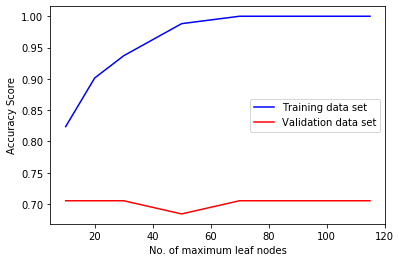

In [29]:
#GridSearch1 accuarcy score plot for validation data set
plt.plot(max_leaf_nodes1,acc_score_train1,'b-',max_leaf_nodes1,acc_score_val1,'r-')
plt.xlabel('No. of maximum leaf nodes')
plt.ylabel('Accuracy Score')
plt.legend(("Training data set","Validation data set",))
plt.show()

In [30]:
#GridSearch 1 accuracy scores for Testing dataset
max_leaf_nodes1=([10,20,30,50,70,90,100,110,115])
acc_score_train1 = []
acc_score_test1 = []
for item in max_leaf_nodes1:
    dt_prune = DecisionTreeClassifier(max_leaf_nodes = item, random_state = 42)
    dt_prune.fit(train_features_flatten, train_labels)
    train_labels_pred_prune = dt_prune.predict(train_features_flatten)
    acc_score_train1.append(accuracy_score(train_labels, train_labels_pred_prune))
    test_labels_pred_prune = dt_prune.predict(test_features_flatten)
    acc_score_test1.append(accuracy_score(test_labels, test_labels_pred_prune))
print(acc_score_train1,'\n',acc_score_test1)

[0.8236842105263158, 0.9013157894736842, 0.9368421052631579, 0.9881578947368421, 1.0, 1.0, 1.0, 1.0, 1.0] 
 [0.7052631578947368, 0.7157894736842105, 0.7263157894736842, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579]


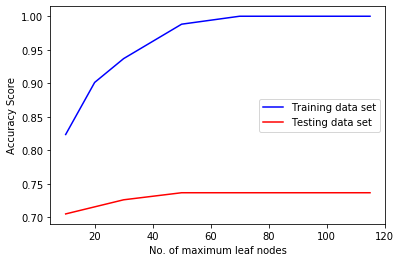

In [31]:
#GridSearch1 accuarcy score plot for testing data set
plt.plot(max_leaf_nodes1,acc_score_train1,'b-',max_leaf_nodes1,acc_score_test1,'r-')
plt.xlabel('No. of maximum leaf nodes')
plt.ylabel('Accuracy Score')
plt.legend(("Training data set","Testing data set",))
plt.show()

In [38]:
#Using GridSearch1's best results to predict training, validation and testing dataset
train_labels_pred_GS = dt1_GS.predict(train_features_flatten)
val_labels_pred_GS = dt1_GS.predict(val_features_flatten)
test_labels_pred_GS = dt1_GS.predict(test_features_flatten)

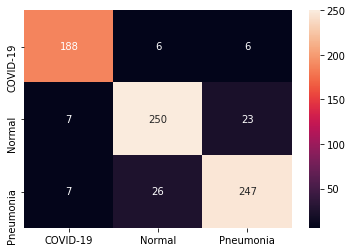

In [39]:
#Confusion matrix plot for GridSearch1's best results on training data set
#fig100 = plt.figure()
# fig100 = plt.figure(figsize=(10,10))
categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(train_labels.argmax(axis=1), train_labels_pred_GS.argmax(axis=1))
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

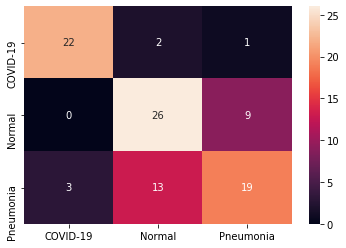

In [40]:
#Confusion matrix plot for GridSearch1's best results on validation data set

categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(val_labels.argmax(axis=1), val_labels_pred_GS.argmax(axis=1))

sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

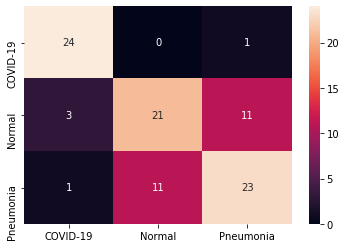

In [41]:
#Confusion matrix plot for GridSearch1's best results on testing data set

categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(test_labels.argmax(axis=1), test_labels_pred_GS.argmax(axis=1))

sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

In [32]:
#Initializing Gridsearch2 for DT to find the optimum parameters

dt_GS2 = GridSearchCV(dt, param_grid={"max_leaf_nodes":[None,5,10,20,40,50,70,90,100]}, cv=5)
dt_GS2.fit(train_features_flatten, train_labels)
results2 = pd.DataFrame(dt_GS2.cv_results_)

In [33]:
print("Best parameters: ", dt_GS2.best_params_,'\n\n')
print(results2[['param_max_leaf_nodes','mean_test_score','rank_test_score']])

Best parameters:  {'max_leaf_nodes': 20} 


  param_max_leaf_nodes  mean_test_score  rank_test_score
0                 None         0.686842                2
1                    5         0.685526                3
2                   10         0.671053                4
3                   20         0.690789                1
4                   40         0.664474                9
5                   50         0.669737                5
6                   70         0.669737                5
7                   90         0.669737                5
8                  100         0.669737                5


In [34]:
#GridSearch 2 accuracy scores for Validation dataset

max_leaf_nodes2=([None,5,10,20,40,50,70,90,100])
acc_score_train2 = []
acc_score_val2 = []
for item in max_leaf_nodes2:
    dt_prune = DecisionTreeClassifier(max_leaf_nodes = item, random_state = 42)
    dt_prune.fit(train_features_flatten, train_labels)
    train_labels_pred_prune = dt_prune.predict(train_features_flatten)
    acc_score_train2.append(accuracy_score(train_labels, train_labels_pred_prune))
    val_labels_pred_prune = dt_prune.predict(val_features_flatten)
    acc_score_val2.append(accuracy_score(val_labels, val_labels_pred_prune))
print(acc_score_train2,'\n',acc_score_val2)

[1.0, 0.7118421052631579, 0.8236842105263158, 0.9013157894736842, 0.9736842105263158, 0.9881578947368421, 1.0, 1.0, 1.0] 
 [0.7263157894736842, 0.6105263157894737, 0.7052631578947368, 0.7052631578947368, 0.6947368421052632, 0.6842105263157895, 0.7052631578947368, 0.7052631578947368, 0.7052631578947368]


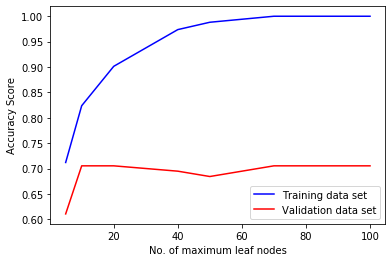

In [35]:
#GridSearch2 accuarcy score plot for validation data set
plt.plot(max_leaf_nodes2,acc_score_train2,'b-',max_leaf_nodes2,acc_score_val2,'r-')
plt.xlabel('No. of maximum leaf nodes')
plt.ylabel('Accuracy Score')
plt.legend(("Training data set","Validation data set",))
plt.show()

In [36]:
#GridSearch 2 accuracy scores for testing dataset

max_leaf_nodes2=([None,5,10,20,40,50,70,90,100])
acc_score_train2 = []
acc_score_test2 = []
for item in max_leaf_nodes2:
    dt_prune = DecisionTreeClassifier(max_leaf_nodes = item, random_state = 42)
    dt_prune.fit(train_features_flatten, train_labels)
    train_labels_pred_prune = dt_prune.predict(train_features_flatten)
    acc_score_train2.append(accuracy_score(train_labels, train_labels_pred_prune))
    test_labels_pred_prune = dt_prune.predict(test_features_flatten)
    acc_score_test2.append(accuracy_score(test_labels, test_labels_pred_prune))
print(acc_score_train2,'\n',acc_score_test2)

[1.0, 0.7118421052631579, 0.8236842105263158, 0.9013157894736842, 0.9736842105263158, 0.9881578947368421, 1.0, 1.0, 1.0] 
 [0.7473684210526316, 0.6631578947368421, 0.7052631578947368, 0.7157894736842105, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579]


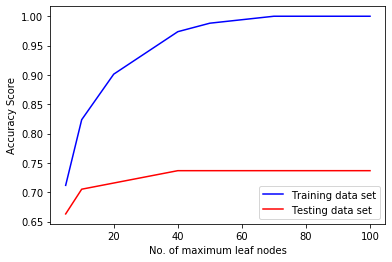

In [37]:
#GridSearch2 accuarcy score plot for testing data set
plt.plot(max_leaf_nodes2,acc_score_train2,'b-',max_leaf_nodes2,acc_score_test2,'r-')
plt.xlabel('No. of maximum leaf nodes')
plt.ylabel('Accuracy Score')
plt.legend(("Training data set","Testing data set",))
plt.show()

In [43]:
#Using GridSearch2's best results to predict training, validation and testing dataset
train_labels_pred_GS2 = dt_GS2.predict(train_features_flatten)
val_labels_pred_GS2 = dt_GS2.predict(val_features_flatten)
test_labels_pred_GS2 = dt_GS2.predict(test_features_flatten)

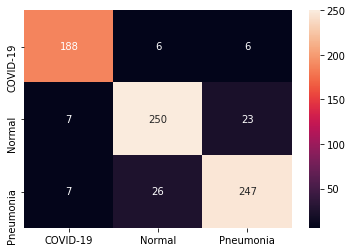

In [44]:
#Confusion matrix plot for GridSearch2's best results on training data set

categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(train_labels.argmax(axis=1), train_labels_pred_GS2.argmax(axis=1))

sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

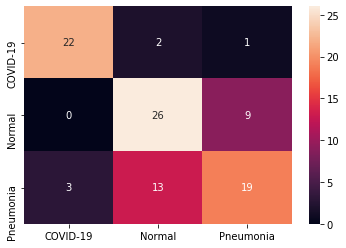

In [45]:
#Confusion matrix plot for GridSearch2's best results on validation data set

categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(val_labels.argmax(axis=1), val_labels_pred_GS2.argmax(axis=1))

sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

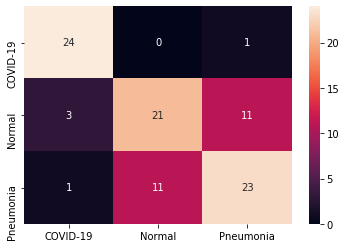

In [46]:
#Confusion matrix plot for GridSearch1's best results on testing data set

categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(test_labels.argmax(axis=1), test_labels_pred_GS2.argmax(axis=1))

sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

In [47]:
#Classification Report & Accuracy Scores on Grid Search 1 & 2 training, validation and testing data - same results can be used as the max leaf nodes returned is 20
print("\n\nClassification Matrix on Training Data:\n\n",classification_report(train_labels, train_labels_pred_GS))

print("\n\nAccuracy on Training Data: ", accuracy_score(train_labels, train_labels_pred_GS))

print("\n\nClassification Matrix on Validation Data:\n\n",classification_report(val_labels, val_labels_pred_GS))

print("\n\nAccuracy on Validation Data: ", accuracy_score(val_labels, val_labels_pred_GS))

print("\n\nClassification Matrix on Testing Data:\n\n",classification_report(test_labels, test_labels_pred_GS))

print("\n\nAccuracy on Testing Data: ", accuracy_score(test_labels, test_labels_pred_GS))



Classification Matrix on Training Data:

               precision    recall  f1-score   support

           0       0.93      0.94      0.94       200
           1       0.89      0.89      0.89       280
           2       0.89      0.88      0.89       280

   micro avg       0.90      0.90      0.90       760
   macro avg       0.90      0.90      0.90       760
weighted avg       0.90      0.90      0.90       760
 samples avg       0.90      0.90      0.90       760



Accuracy on Training Data:  0.9013157894736842


Classification Matrix on Validation Data:

               precision    recall  f1-score   support

           0       0.88      0.88      0.88        25
           1       0.63      0.74      0.68        35
           2       0.66      0.54      0.59        35

   micro avg       0.71      0.71      0.71        95
   macro avg       0.72      0.72      0.72        95
weighted avg       0.71      0.71      0.70        95
 samples avg       0.71      0.71      0.71   